# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
# Set seaborn style
sns.set(style="whitegrid")


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them

def combine_stock_data(file_list):
    dataframes = []

    for file_path in file_list:
        # Extract stock name from filename
        stock_name = os.path.basename(file_path).split('_')[0]

        # Read the CSV
        df = pd.read_csv(file_path)

        # Add a new column for the stock name
        df['Stock'] = stock_name

        # Optionally, drop unnecessary columns
        # (assuming 'Unnamed: 0' or similar)
        if 'Unnamed: 0' in df.columns:
            df = df.drop(columns=['Unnamed: 0'])

        # Append to list
        dataframes.append(df)

    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

# Example usage
file_list = [
    'https://github.com/pankaj8blr/RNN-Stock-Price-Prediction/tree/2eabcaa2d00607cbbbd0cad05ae5d4b212c915e5/RNN_Stocks_Data/AMZN_stocks_data.csv'
    # 'https://github.com/pankaj8blr/RNN-Stock-Price-Prediction/tree/2eabcaa2d00607cbbbd0cad05ae5d4b212c915e5/RNN_Stocks_Data/GOOGL_stocks_data.csv',
    # 'https://github.com/pankaj8blr/RNN-Stock-Price-Prediction/tree/2eabcaa2d00607cbbbd0cad05ae5d4b212c915e5/RNN_Stocks_Data/IBM_stocks_data.csv',
    # 'https://github.com/pankaj8blr/RNN-Stock-Price-Prediction/tree/2eabcaa2d00607cbbbd0cad05ae5d4b212c915e5/RNN_Stocks_Data/MSFT_stocks_data.csv'
]

combined_data = combine_stock_data(file_list)

# Display the combined DataFrame
print(combined_data.head())

ParserError: Error tokenizing data. C error: Expected 1 fields in line 42, saw 50


### View specifics of the data ###

In [ ]:
# View specifics of the data
print(f"Shape of combined data: {combined_data.shape}")


print("Column names:")
print(combined_data.columns.tolist())


print("First 5 rows:")
print(combined_data.head())


print("Data types and missing values:")
print(combined_data.info())


print("Statistical Summary:")
print(combined_data.describe())

Shape of combined data: (12077, 8)
Column names:
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name', 'Stock']
First 5 rows:
         Date   Open   High    Low  Close   Volume  Name Stock
0  2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN  AMZN
1  2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN  AMZN
2  2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN  AMZN
3  2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN  AMZN
4  2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN  AMZN
Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
 7   Stock   12077 

#### Summary ####
- Shape: 12,077 rows × 8 columns

- Columns:
    - Date (object/string)
    - Open (float)
    - High (float)
    - Low (float)
    - Close (float)
    - Volume (int)
    - Name (object/string) — seems to repeat the stock name
    - Stock (object/string) — the one we added for stock identity
- Data Types & Nulls:
    - No major missing data (Open and Low have only 1 missing value out of 12077 rows).
    - All numeric columns are floats/ints.
    - Date, Name, and Stock are strings (object dtype).
- Observations:
    - Stock prices range widely (from ~$15 up to $1200+), which makes sense because you have  companies like Amazon and Google here.
    - Volume is huge for some days — up to nearly 600 million

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [ ]:
# Handle Missing Values

combined_data.isnull().sum()

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
Stock     0
dtype: int64

In [ ]:
combined_data.fillna(method='ffill')

C:\Users\archi\AppData\Local\Temp\ipykernel_20632\1154399362.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill')


,Date,Open,High,Low,Close,Volume,Name,Stock
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,AMZN
...,...,...,...,...,...,...,...,...
12072,2017-12-22,85.40,85.63,84.92,85.51,14145841,MSFT,MSFT
12073,2017-12-26,85.31,85.53,85.03,85.40,9891237,MSFT,MSFT
12074,2017-12-27,85.65,85.98,85.22,85.71,14678025,MSFT,MSFT
12075,2017-12-28,85.90,85.93,85.55,85.72,10594344,MSFT,MSFT


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [ ]:
# Convert 'Date' to datetime for time-based plots
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

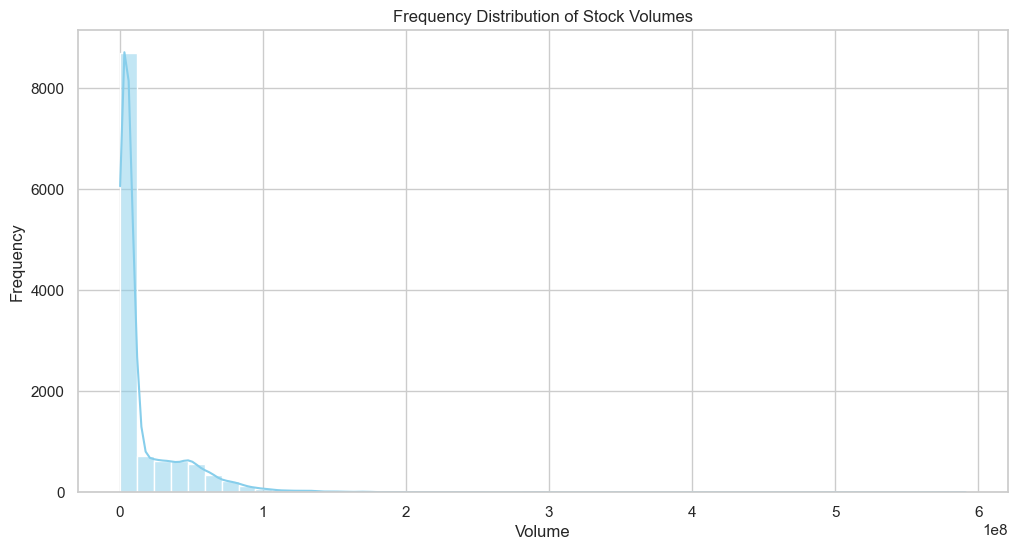

In [ ]:
# Frequency distribution of volumes
plt.figure(figsize=(12,6))
sns.histplot(combined_data['Volume'], bins=50, kde=True, color='skyblue')
plt.title('Frequency Distribution of Stock Volumes')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()



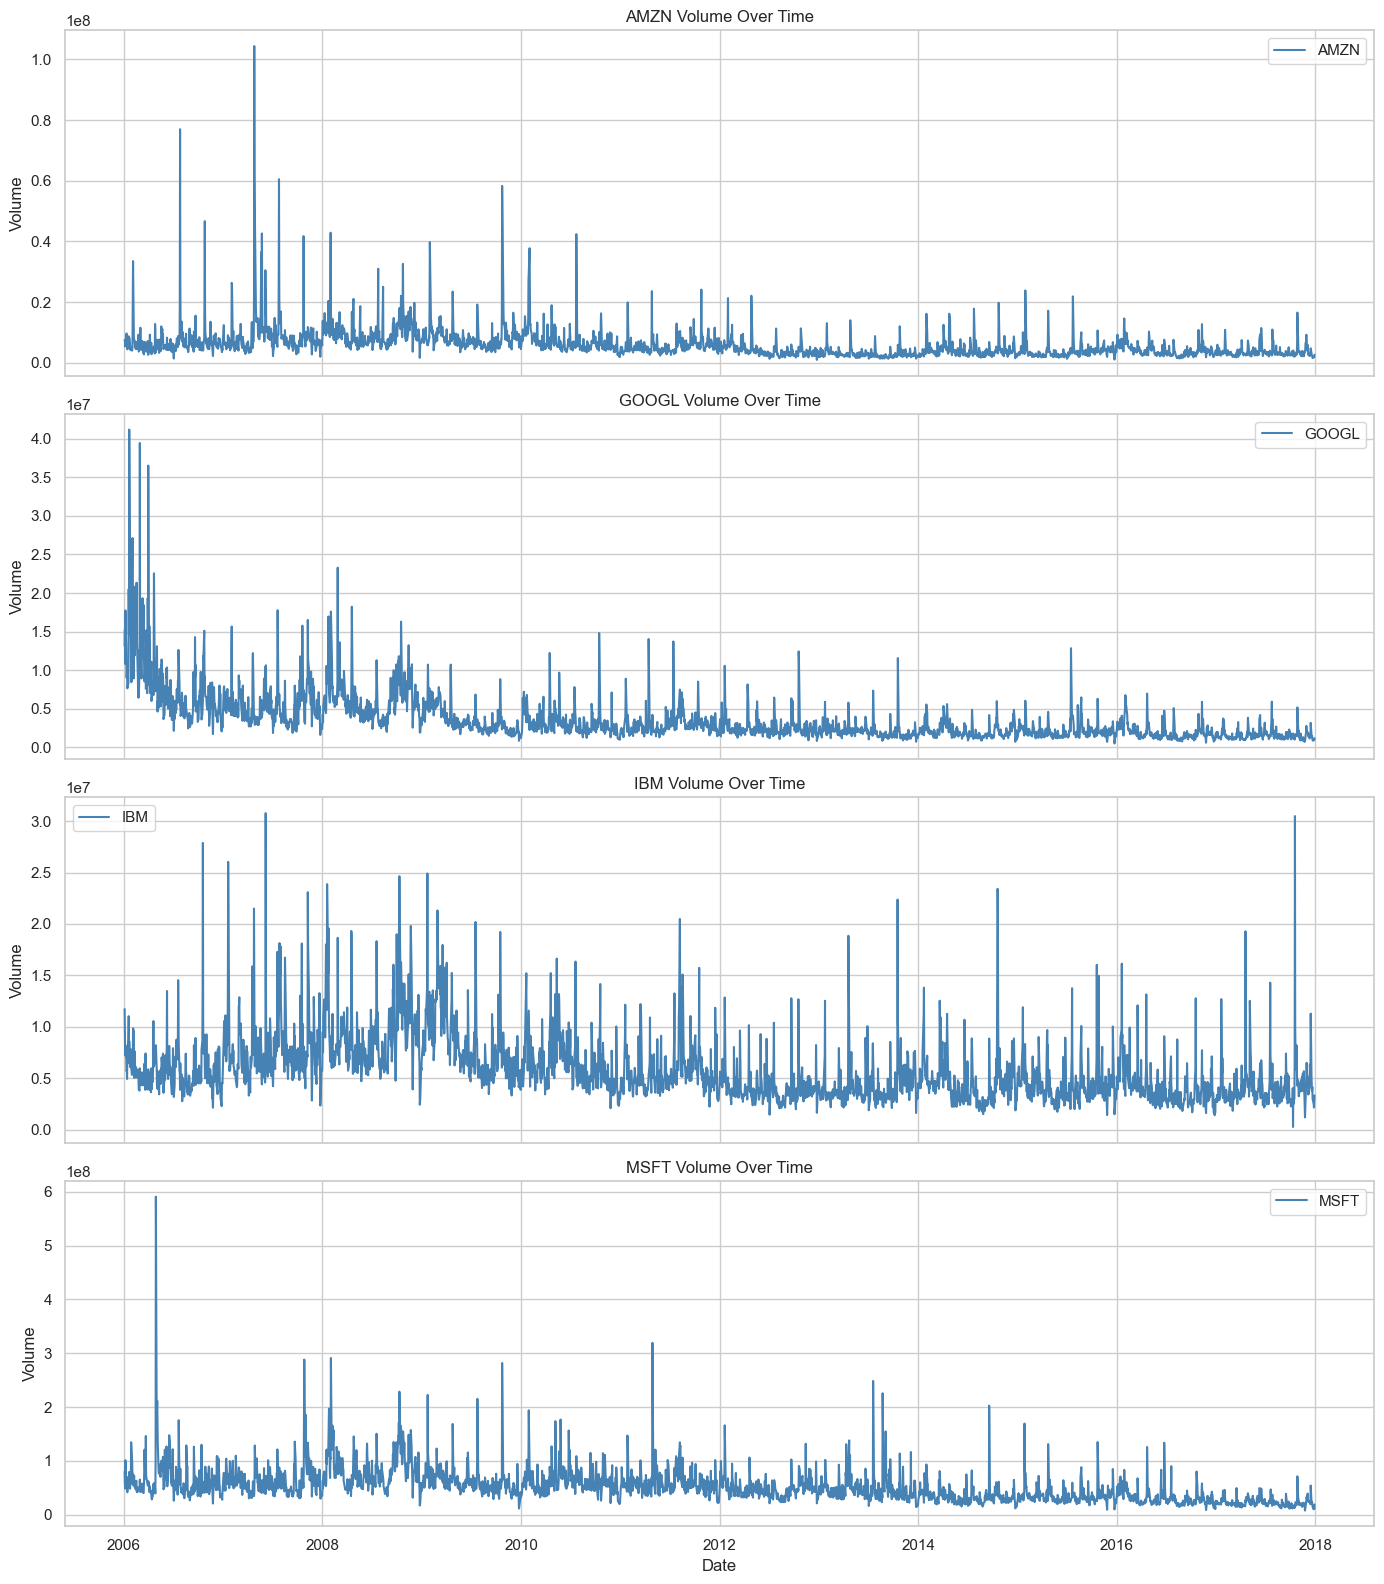

In [ ]:
unique_stocks = combined_data['Stock'].unique()
num_stocks = len(unique_stocks)

fig, axs = plt.subplots(num_stocks, 1, figsize=(14, num_stocks*4), sharex=True)

for i, stock in enumerate(unique_stocks):
    stock_data = combined_data[combined_data['Stock'] == stock]
    axs[i].plot(stock_data['Date'], stock_data['Volume'], label=stock, color='steelblue')
    axs[i].set_title(f'{stock} Volume Over Time')
    axs[i].set_ylabel('Volume')
    axs[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

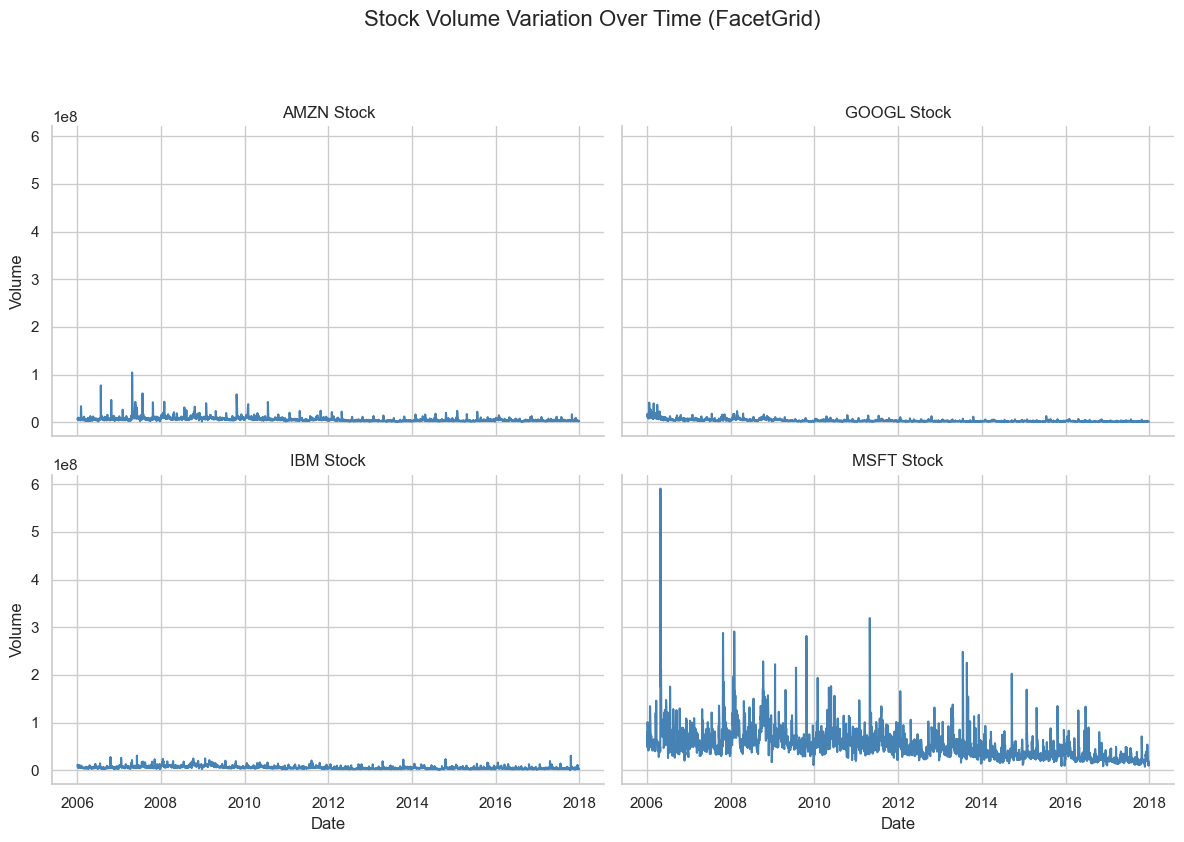

In [ ]:
g = sns.FacetGrid(combined_data, col="Stock", col_wrap=2, height=4, aspect=1.5)
g.map_dataframe(sns.lineplot, x="Date", y="Volume", color="steelblue")
g.set_axis_labels("Date", "Volume")
g.set_titles("{col_name} Stock")
g.fig.suptitle('Stock Volume Variation Over Time (FacetGrid)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

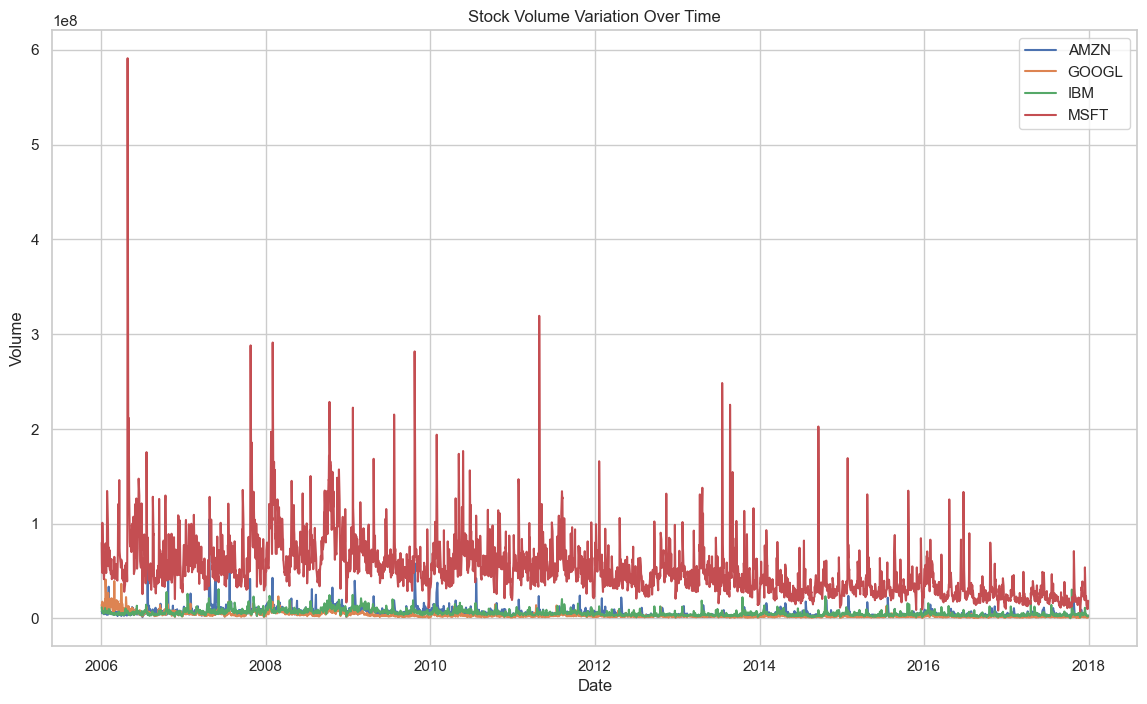

In [ ]:
# Stock volume variation over time
plt.figure(figsize=(14,8))
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]
    plt.plot(stock_data['Date'], stock_data['Volume'], label=stock)

plt.title('Stock Volume Variation Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [ ]:
# Analyse correlations

correlation_matrix = combined_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()


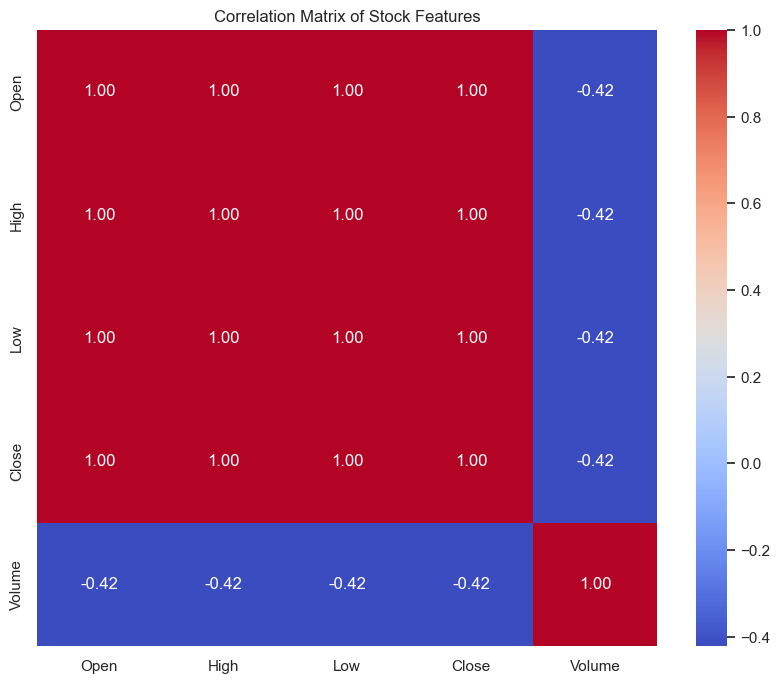


Correlation Matrix:
            Open      High       Low     Close    Volume
Open    1.000000  0.999945  0.999919  0.999873 -0.420741
High    0.999945  1.000000  0.999907  0.999935 -0.421083
Low     0.999919  0.999907  1.000000  0.999945 -0.420673
Close   0.999873  0.999935  0.999945  1.000000 -0.420875
Volume -0.420741 -0.421083 -0.420673 -0.420875  1.000000


In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Stock Features')
plt.show()

# Optional: Display correlation matrix as text
print("\nCorrelation Matrix:")
print(correlation_matrix)

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [ ]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, stock_names, window_size=10, stride=1):
    """
    Creates windowed X and y for selected stocks.

    Parameters:
        df (DataFrame): Master combined stock data
        stock_names (list): List of stock names to predict
        window_size (int): Length of each input window
        stride (int): Stride to slide windows
    Returns:
        X, y (both numpy arrays)
    """
    X = []
    y = []

    # Filter for selected stocks
    df_selected = df[df['Stock'].isin(stock_names)]

    # Sort by Date to maintain temporal order
    df_selected = df_selected.sort_values(['Stock', 'Date'])

    # Group by Stock so that windows don't mix companies
    for stock, group in df_selected.groupby('Stock'):
        features = group[['Open', 'High', 'Low', 'Close', 'Volume']].values
        target = group['Close'].values

        for i in range(0, len(features) - window_size, stride):
            X.append(features[i:i+window_size])
            y.append(target[i+window_size])  # Target is the Close price *after* the window

    return np.array(X), np.array(y)

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [ ]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def split_train_test(X, y, test_size=0.2):
    """
    Splits X and y into training and testing sets.
    """
    return train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)  # No shuffle because it's time series

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [ ]:
# Define a function to create input and output data points from the master DataFrame

# 2. Train-Test Split
def split_train_test(X, y, test_size=0.2):
    """
    Splits X and y into training and testing sets.
    """
    return train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)  # No shuffle because it's time series

# 3. Scaling Function
def scale_windowed_data(X_train, X_test):
    """
    Scales windowed data feature-wise.

    Each feature across all windows and timesteps is scaled separately.
    """
    n_timesteps = X_train.shape[1]
    n_features = X_train.shape[2]

    # Reshape to (samples * timesteps, features) for scaling
    X_train_reshaped = X_train.reshape(-1, n_features)
    X_test_reshaped = X_test.reshape(-1, n_features)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    # Reshape back to original 3D form
    X_train_scaled = X_train_scaled.reshape(-1, n_timesteps, n_features)
    X_test_scaled = X_test_scaled.reshape(-1, n_timesteps, n_features)

    return X_train_scaled, X_test_scaled, scaler

# 4. Main Wrapper Function
def prepare_windowed_data(df, stock_names, window_size=10, stride=1, test_size=0.2):
    """
    Full pipeline: Windowing, Train-Test Split, Scaling.

    Returns:
        X_train_scaled, y_train, X_test_scaled, y_test
    """
    # Step 1: Window the data
    X, y = create_windowed_data(df, stock_names, window_size, stride)

    # Step 2: Train-test split
    X_train, X_test, y_train, y_test = split_train_test(X, y, test_size)

    # Step 3: Scale the data
    X_train_scaled, X_test_scaled, scaler = scale_windowed_data(X_train, X_test)

    return X_train_scaled, y_train, X_test_scaled, y_test, scaler

In [ ]:
stock_list = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
window_size = 20
stride = 1
test_size = 0.2

X_train, y_train, X_test, y_test, scaler = prepare_windowed_data(
    combined_data,
    stock_list,
    window_size=window_size,
    stride=stride,
    test_size=test_size
)

print(f"Train X shape: {X_train.shape}")
print(f"Train y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Test y shape: {y_test.shape}")

Train X shape: (9597, 20, 5)
Train y shape: (9597,)
Test X shape: (2400, 20, 5)
Test y shape: (2400,)


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

C:\Users\archi\AppData\Local\Temp\ipykernel_20632\1025129564.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Monthly': stock_df['Close'].resample('M').mean(),
C:\Users\archi\AppData\Local\Temp\ipykernel_20632\1025129564.py:16: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  'Quarterly': stock_df['Close'].resample('Q').mean()


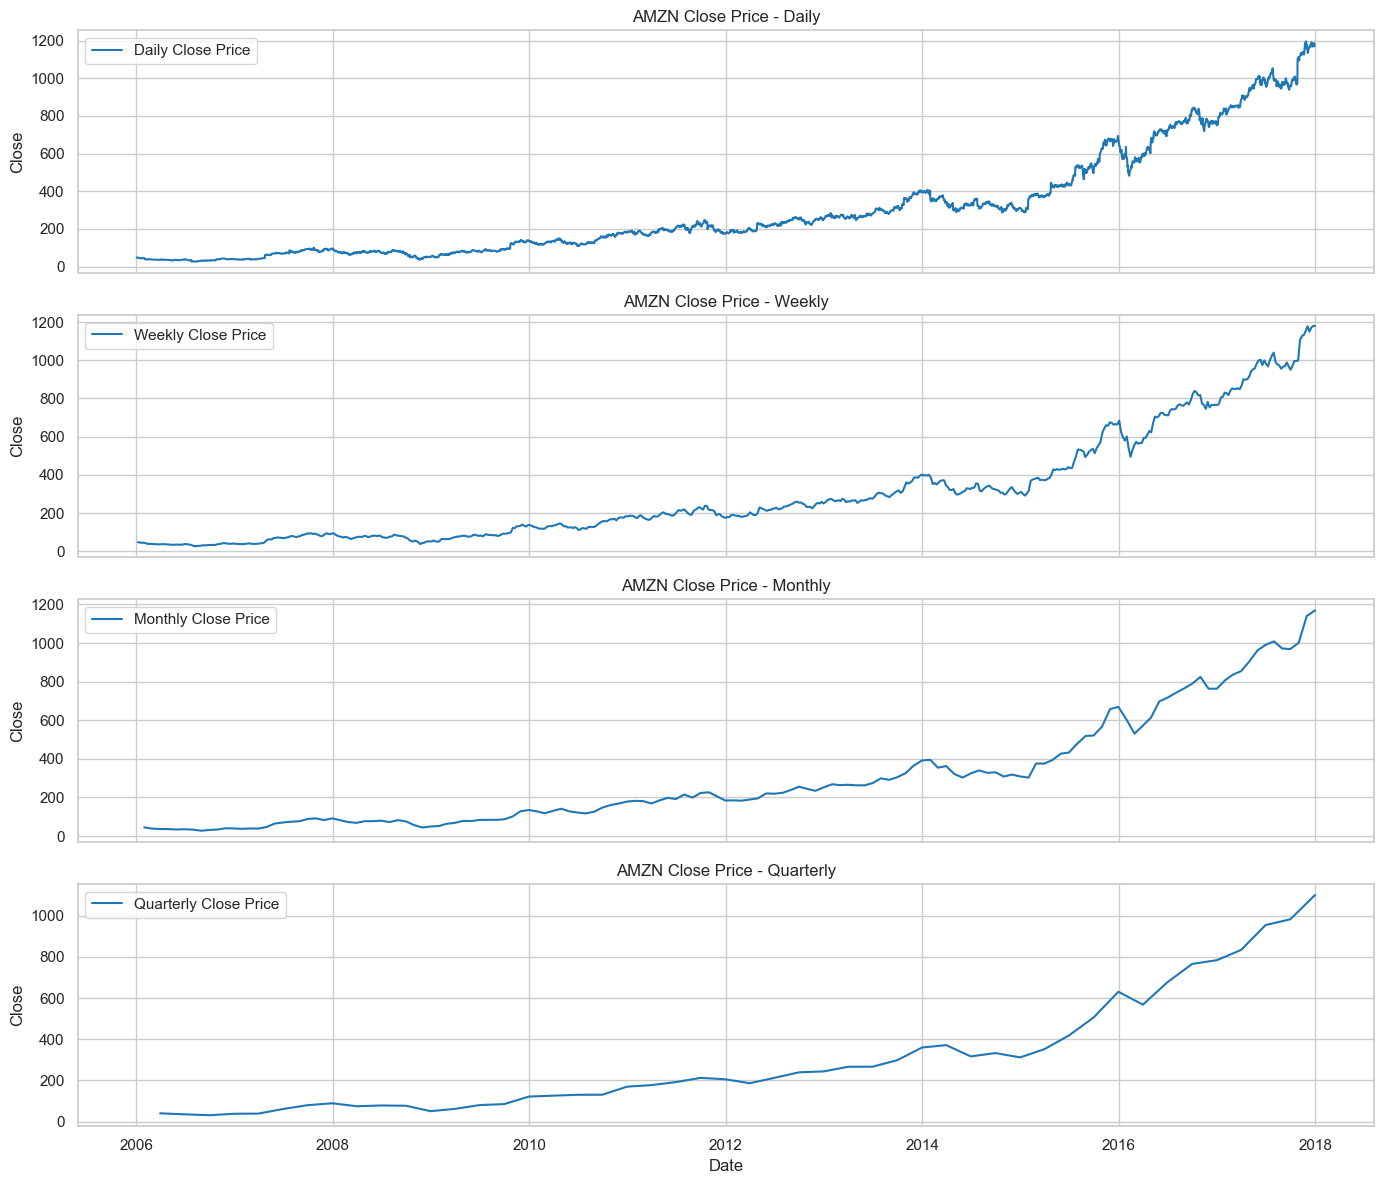

In [ ]:
# Checking for patterns in different sequence lengths
# Make sure 'Date' is datetime
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Pick one stock to analyze patterns (e.g., AMZN)
# stock_to_analyze = file_list[0]
stock_to_analyze = 'AMZN'
stock_df = combined_data[combined_data['Stock'] == stock_to_analyze].copy()
stock_df.set_index('Date', inplace=True)

# Resampling to Weekly, Monthly, Quarterly Close Price
resampled = {
    'Daily': stock_df['Close'],
    'Weekly': stock_df['Close'].resample('W').mean(),
    'Monthly': stock_df['Close'].resample('M').mean(),
    'Quarterly': stock_df['Close'].resample('Q').mean()
}

# Plot all resolutions
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

for i, (freq, series) in enumerate(resampled.items()):
    axes[i].plot(series.index, series.values, label=f'{freq} Close Price', color='tab:blue')
    axes[i].set_title(f'{stock_to_analyze} Close Price - {freq}')
    axes[i].set_ylabel('Close')
    axes[i].legend(loc='upper left')

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()



#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride

import numpy as np

# Create windowed data function
def create_windowed_data_instances(df, stock_names, window_size=30, stride=1):
    """
    Create data instances (X, y) from master DataFrame using window size and stride.

    Parameters:
    - df: master stock dataframe
    - stock_names: list of stock names to consider
    - window_size: number of timesteps in each input window
    - stride: how much to slide the window forward

    Returns:
    - X: numpy array of windowed input sequences
    - y: numpy array of target close prices
    """
    X = []
    y = []

    # Filter only the required stocks
    df_filtered = df[df['Stock'].isin(stock_names)].copy()

    # Sort data properly
    df_filtered = df_filtered.sort_values(by=['Stock', 'Date'])

    # Group by stock so windows don't cross companies
    for stock, stock_df in df_filtered.groupby('Stock'):
        features = stock_df[['Open', 'High', 'Low', 'Close', 'Volume']].values
        target = stock_df['Close'].values

        for i in range(0, len(features) - window_size, stride):
            X.append(features[i:i+window_size])
            y.append(target[i+window_size])  # Target is the Close price after the window

    return np.array(X), np.array(y)

# -----------------------------------

# Example: Create instances
chosen_stocks = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
window_size = 30  # 30 days window
stride = 1  # move window 1 day at a time

X, y = create_windowed_data_instances(combined_data, chosen_stocks, window_size, stride)

print(f"X shape: {X.shape}")  # (samples, window_size, features)
print(f"y shape: {y.shape}")  # (samples,)


X shape: (11957, 30, 5)
y shape: (11957,)


In [ ]:
# Check the number of data points generated
print(f"Number of X (input) instances: {X.shape[0]}")
print(f"Number of y (target) instances: {y.shape[0]}")

# Double-check that X and y match
assert X.shape[0] == y.shape[0], "Mismatch between X and y instances!"


Number of X (input) instances: 11957
Number of y (target) instances: 11957


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks

# 1. Check shapes
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 2. Check missing values
print(f"Any NaN in X? {np.isnan(X).any()}")
print(f"Any NaN in y? {np.isnan(y).any()}")

# 3. Check data types
print(f"X dtype: {X.dtype}")
print(f"y dtype: {y.dtype}")

# 4. Optional: Ensure y is 2D (reshaped if needed)
if len(y.shape) == 1:
    y = y.reshape(-1, 1)
    print(f"y reshaped to: {y.shape}")


X shape: (11957, 30, 5)
y shape: (11957,)
Any NaN in X? True
Any NaN in y? False
X dtype: float64
y dtype: float64
y reshaped to: (11957, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn_model(input_shape,
                             rnn_units=50,
                             dense_units=1,
                             dropout_rate=0.2,
                             optimizer='adam',
                             loss='mse'):
    """
    Function to create a simple RNN model with configurable arguments.

    Parameters:
    - input_shape: tuple, shape of input (timesteps, features)
    - rnn_units: int, number of units in the RNN layer
    - dense_units: int, number of output units (default 1 for regression)
    - dropout_rate: float, dropout rate after RNN
    - optimizer: optimizer to use
    - loss: loss function to use

    Returns:
    - model: compiled RNN model
    """
    model = Sequential()

    # RNN layer
    model.add(SimpleRNN(units=rnn_units, input_shape=input_shape, return_sequences=False))

    # Dropout layer
    model.add(Dropout(rate=dropout_rate))

    # Dense output layer
    model.add(Dense(units=dense_units))

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration based on evaluation metrics



#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model



Plotting the actual vs predicted values

In [ ]:
# Predict on the test data and plot



It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set



### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# # Define a function to create a model and specify default values for hyperparameters



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration



#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set


Plotting the actual vs predicted values

In [ ]:
# Predict on the test data


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.